# **Stock Analysis with Spark**

The goal of this project is to use Spark to develop a Python application that extracts meaningful insights from the data, providing valuable information for people who interested in investing in stocks.
To do so, we will analyse five (05) stocks:

* **AAPL** : Apple Inc. stock - Technology Sector
  
* **JPM** : JPMorgan Chase & Co. stock - Financial Sector

* **META** : Meta Platforms Inc. stock - Communication Services/Social Media Sector

* **NVDA** : Nvidia Corporation stock - Semiconductors/AI Sector

* **TSLA** : Tesla Inc. stock - Automotive/Energy Sector


For our analysis, we will consider the last **3 years** (**2022**, **2023** and **2024**) of each stock data. Note that, as the current year is not finished yet and we also want up-to-date data for our analysis. **We will consider 2024 as the period : 2024-01-01 - 2024-11-19**.

## **Exploration**

**Importing the required libraries**

In [ ]:
# PySpark necessary classes/functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when

# To work on dates
from datetime import datetime, date

# For data visualization purposes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# API to get the data of the stocks
import yfinance as yf

**Creating a Spark application**

In [ ]:
spark = SparkSession.builder.appName("Stock Analysis").getOrCreate()

We will firstly load the data of the five stocks in a dictionary to make the exploration and the processing easier.

In [ ]:
# Stocks to analyze
stocks = ["AAPL", "JPM", "META", "NVDA", "TSLA"]

# Period
start_date = '2022-01-01'
end_date = '2024-11-20'

# Loop to download the stock data during the specified period
stock_map = {}
for stock in stocks:
  ticker = yf.Ticker(stock)
  df = ticker.history(start=start_date, end=end_date).reset_index() # .reset_index() is to transform the "Date" index to a column
  stock_map[stock] = spark.createDataFrame(df) # from Pandas to Spark Dataframe

Overview of the schema of the data

In [ ]:
stock_map["AAPL"].printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- Dividends: double (nullable = true)
 |-- Stock Splits: double (nullable = true)



The inference of the types by Spark/Pandas seems to be good. So, a particular conversion is not needed.

Before going to the exploration, let's have a gist of all of the **8 variables**.



*   **Date** : This represents a specific date on the stock market.
*   **Open**: This is the first traded price of the day.
*   **High**: This the highest trading price of the day.
*   **Low**: This is the lowest trading price of the day.
*   **Close**: This is the raw price or cash value of the last transacted price in a security before the market officially closes for normal trading. Note that the close price of a specific date is not necessarily the opening price of the next day because some transactions (buy/sell) can be done overnight.
*   **Volume**: This represents the total number of shares traded during the day. Volume indicates the level of trading activity, and high volume often suggests greater interest This is the amount of dividend issued per share for that date. Dividends are periodic payments made by a company to its shareholders, typically from profits, and can affect a stock's price as they reflect the company's profitability.
*   **Stock Splits**: This shows any stock splits that occurred on that date. A stock split increases the number of shares in circulation by issuing additional shares to existing shareholders.



**Displaying the first and the last 40 rows of each stock**

We will use **.head** and **.tail** functions to do that.

In [ ]:
for stock in stock_map:
  print(stock)
  print("The first 40 rows")
  spark.createDataFrame(stock_map[stock].head(40)).show(40)
  print("The last 40 rows")
  spark.createDataFrame(stock_map[stock].tail(40)).show(40)
  print()

AAPL
The first 40 rows
+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|               Date|              Open|              High|               Low|             Close|   Volume|Dividends|Stock Splits|
+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|2022-01-03 05:00:00|174.96395910795226| 179.9325724934608| 174.8458979227722| 179.0765838623047|104487900|      0.0|         0.0|
|2022-01-04 05:00:00|179.68661899764498| 179.9916204306624|176.23317886967382| 176.8038330078125| 99310400|      0.0|         0.0|
|2022-01-05 05:00:00|176.71527555574892|177.26624778747964|171.82537447983776|172.10086059570312| 94537600|      0.0|         0.0|
|2022-01-06 05:00:00|169.91662049000044|172.47472273765217|168.87370673165287| 169.2279052734375| 96904000|      0.0|         0.0|
|2022-01-07 05:00:00|170.10356923829096|171.33342326280658|1

**Number of observations and variables of each stock**

In [ ]:
for stock in stock_map:
  print("The dataframe of the stock", stock, "has", stock_map[stock].count(), "observations with", len(stock_map[stock].columns), "variables.")

The dataframe of the stock AAPL has 725 observations with 8 variables.
The dataframe of the stock JPM has 725 observations with 8 variables.
The dataframe of the stock META has 725 observations with 8 variables.
The dataframe of the stock NVDA has 725 observations with 8 variables.
The dataframe of the stock TSLA has 725 observations with 8 variables.


For all of the dataframes, there are **725 observations** and **8 variables**.

**Number of days between each two consecutive rows**



To do so, we'll do a **self join** followed by the use of the **datediff** function.

But, we have a problem here. Without indexes, we can't have an efficient join. So, we begin by adding an **index** column at the begining of all of the dataframes.

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

for stock in stock_map:
  stock_map[stock] = stock_map[stock].select((monotonically_increasing_id()).alias("id"), "*")

stock_map["AAPL"].show(5)

+---+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
| id|               Date|              Open|              High|               Low|             Close|   Volume|Dividends|Stock Splits|
+---+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|  0|2022-01-03 05:00:00|174.96395910795226| 179.9325724934608| 174.8458979227722| 179.0765838623047|104487900|      0.0|         0.0|
|  1|2022-01-04 05:00:00|179.68661899764498| 179.9916204306624|176.23317886967382| 176.8038330078125| 99310400|      0.0|         0.0|
|  2|2022-01-05 05:00:00|176.71527555574892|177.26624778747964|171.82537447983776|172.10086059570312| 94537600|      0.0|         0.0|
|  3|2022-01-06 05:00:00|169.91662049000044|172.47472273765217|168.87370673165287| 169.2279052734375| 96904000|      0.0|         0.0|
|  4|2022-01-07 05:00:00|170.10356923829096|171.3334232

To accomplish our goal, we'll do a join on the condition **df1.id + 1 = df2.id** in order to consider two consecutive rows each time.

In [ ]:
from pyspark.sql.functions import max, datediff

def get_period(df):
  # Get the differences
  diff_df = (df.alias("df1")
             .join(other=df.alias("df2"), on=(col("df1.id") + 1 == col("df2.id")), how="inner")
             .withColumn("diff", datediff(col("df2.Date"), col("df1.Date"))) # Create a new column diff to get the difference between dates
             .groupBy("diff")
             .count())

  # Get the most common difference
  most_common = diff_df.filter(diff_df.diff == max(diff_df.diff)).collect()[0][0]

  # Deduce the period
  if most_common == 1:
    period = "day period"
  elif most_common == 7:
    period = "week period"
  elif most_common in range(28, 32):
    period = "month period"
  elif most_common in range(89, 93):
    period = "quarter period"
  elif most_common in range(365, 367):
    period = "year period"
  else:
    period = f"{most_common} days period"

  return period

In [ ]:
for stock in stock_map:
  period = get_period(stock_map[stock])
  print(f"The period between data points for the stock {stock} is {period}.")
  print()

The period between data points for the stock AAPL is day period.

The period between data points for the stock JPM is day period.

The period between data points for the stock META is day period.

The period between data points for the stock NVDA is day period.

The period between data points for the stock TSLA is day period.



We notice all of the stocks the period between data points is a **day period**.

**Descriptive Statistics**

In [ ]:
for stock in stock_map:
  print(stock)
  stock_map[stock].drop("id").describe().show() # "id" column is not needed for the descriptive statistics
  print()

AAPL
+-------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------+
|summary|              Open|              High|               Low|             Close|              Volume|           Dividends|Stock Splits|
+-------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------+
|  count|               725|               725|               725|               725|                 725|                 725|         725|
|   mean|174.19980513884437|176.05456117710239| 172.4941688096064|174.35835721772293| 6.893013613793103E7|0.003931034482758621|         0.0|
| stddev|26.899596415101765|26.841428563129238|26.891500396489217|26.892615519863554|2.8225012916705064E7| 0.03034553658743236|         0.0|
|    min| 124.6986773645302|126.44036106917035|122.87781986866916|123.71897888183594|            24048300|                 0.0|         0.0|
|    max

**Observations**

* **META** has the highest **maximum** while **AAPL** has the highest **minimum** prices for the **Open**, **High**, **Low** and **Close** prices.

* **NVDA** has the **biggest mean of volume traded**. It is **18x more than META** or even **42x more than JPM**. **NVDA** has also the highest maximum volume of trades during a day, going above **1 billion in volume**.

* The **Open**, **High**, **Low** and **Close** prices of **NVDA** are very low compared with other stocks.

* **TSLA** is the only one that doesn't give any dividend during the considered period.

* There are no stock splits for the **AAPL**, **JPM** and **META** stocks during the considered period. That means there is no division of the shares. For the remaining stocks, even though the mean is more than zero for the stock splits, we can notice numbers are very small.



**Number of missing values for each dataframe and column**

In [ ]:
from pyspark.sql.functions import count

for stock in stock_map:
  print(stock)
  #  Date/Timestamp types are not supported by isnan function so we convert the Date column (not on the original dataframe) to the String type
  df = stock_map[stock].withColumn("Date", col("Date").cast("string"))
  # Note that, in PySpark, there is a difference between nan values (for example division by zero) and null values (absence of a value).
  missing_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]) # Total for each column
  missing_df = missing_df.withColumn("Total of missing values", sum(col(c) for c in df.columns))
  missing_df.show()
  print()

AAPL
+---+----+----+----+---+-----+------+---------+------------+-----------------------+
| id|Date|Open|High|Low|Close|Volume|Dividends|Stock Splits|Total of missing values|
+---+----+----+----+---+-----+------+---------+------------+-----------------------+
|  0|   0|   0|   0|  0|    0|     0|        0|           0|                      0|
+---+----+----+----+---+-----+------+---------+------------+-----------------------+


JPM
+---+----+----+----+---+-----+------+---------+------------+-----------------------+
| id|Date|Open|High|Low|Close|Volume|Dividends|Stock Splits|Total of missing values|
+---+----+----+----+---+-----+------+---------+------------+-----------------------+
|  0|   0|   0|   0|  0|    0|     0|        0|           0|                      0|
+---+----+----+----+---+-----+------+---------+------------+-----------------------+


META
+---+----+----+----+---+-----+------+---------+------------+-----------------------+
| id|Date|Open|High|Low|Close|Volume|Dividends|

There are **no nan/null values** in the different columns of the five dataframes.


**Correlation between values**

The **Pearson correlation** is already implemented in the **.corr** method of the dataframes. So, we will use it.

As seen previously, **Dividends** and **Stock Splits** variables barely change. They mostly take the value 0. Also, the variable **Date** is unique for each observation. So, we will discard the three variables : **Dividends**, **Stock Splits** and **Date** for the correlation checking.

**Correlation between variables of the same stock**

In [ ]:
columns = ["Open", "High", "Low", "Close", "Volume"]

In [ ]:
%%time

for stock in stock_map:
  print(stock)
  df = stock_map[stock]
  for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        print("Correlation between", columns[i], "and", columns[j], "is",
              np.round(df.corr(columns[i], columns[j]), 5))
  print()

AAPL
Correlation between Open and High is 0.99816
Correlation between Open and Low is 0.99843
Correlation between Open and Close is 0.99608
Correlation between Open and Volume is -0.39227
Correlation between High and Low is 0.99805
Correlation between High and Close is 0.99835
Correlation between High and Volume is -0.37213
Correlation between Low and Close is 0.99833
Correlation between Low and Volume is -0.40754
Correlation between Close and Volume is -0.39089

JPM
Correlation between Open and High is 0.99944
Correlation between Open and Low is 0.99926
Correlation between Open and Close is 0.99861
Correlation between Open and Volume is -0.31557
Correlation between High and Low is 0.99923
Correlation between High and Close is 0.99934
Correlation between High and Volume is -0.30707
Correlation between Low and Close is 0.99946
Correlation between Low and Volume is -0.32832
Correlation between Close and Volume is -0.31925

META
Correlation between Open and High is 0.99967
Correlation bet

Considering the five (05) stocks, **Open**, **High**, **Low** and **Close** prices seem to have a perfect correlation one with the others (> 0.98). Negative correlations between **Volume** and other prices are noticed for some stocks but they are not that strong to be considered.

**Correlation between the same variables of different stocks**

In [ ]:
%%time

stocks = list(stock_map.keys())

for _col in columns:
  print(f"Correlation for the variable {_col}")
  for i in range(len(stocks)):
    for j in range(i+1, len(stocks)):
      df1 = stock_map[stocks[i]].select("Date", col(_col).alias("st1"))
      df2 = stock_map[stocks[j]].select("Date", col(_col).alias("st2"))
      new_df = df1.join(other=df2, on="Date", how="inner")
      print("Correlation between", stocks[i], _col, "and", stocks[j], _col, "is",
              np.round(new_df.corr("st1", "st2"), 5))
  print()

Correlation for the variable Open
Correlation between AAPL Open and JPM Open is 0.85226
Correlation between AAPL Open and META Open is 0.8683
Correlation between AAPL Open and NVDA Open is 0.87809
Correlation between AAPL Open and TSLA Open is 0.14916
Correlation between JPM Open and META Open is 0.94969
Correlation between JPM Open and NVDA Open is 0.96482
Correlation between JPM Open and TSLA Open is -0.16429
Correlation between META Open and NVDA Open is 0.95353
Correlation between META Open and TSLA Open is -0.07887
Correlation between NVDA Open and TSLA Open is -0.13863

Correlation for the variable High
Correlation between AAPL High and JPM High is 0.85262
Correlation between AAPL High and META High is 0.86796
Correlation between AAPL High and NVDA High is 0.88011
Correlation between AAPL High and TSLA High is 0.14334
Correlation between JPM High and META High is 0.94909
Correlation between JPM High and NVDA High is 0.96547
Correlation between JPM High and TSLA High is -0.16639
C

We can notice that there are strongs correlations between the first four variables (**Open**, **Low**, **High** and **Close**) of the different stocks except **TSLA**. There are no correlations about the **Volume** of the different stocks.

Before moving to advanced exploration. Let's take a look at the line plots of these different values for the five stocks.

As there is strong correlations between the different stocks, we will considerate the closing price for our plot.

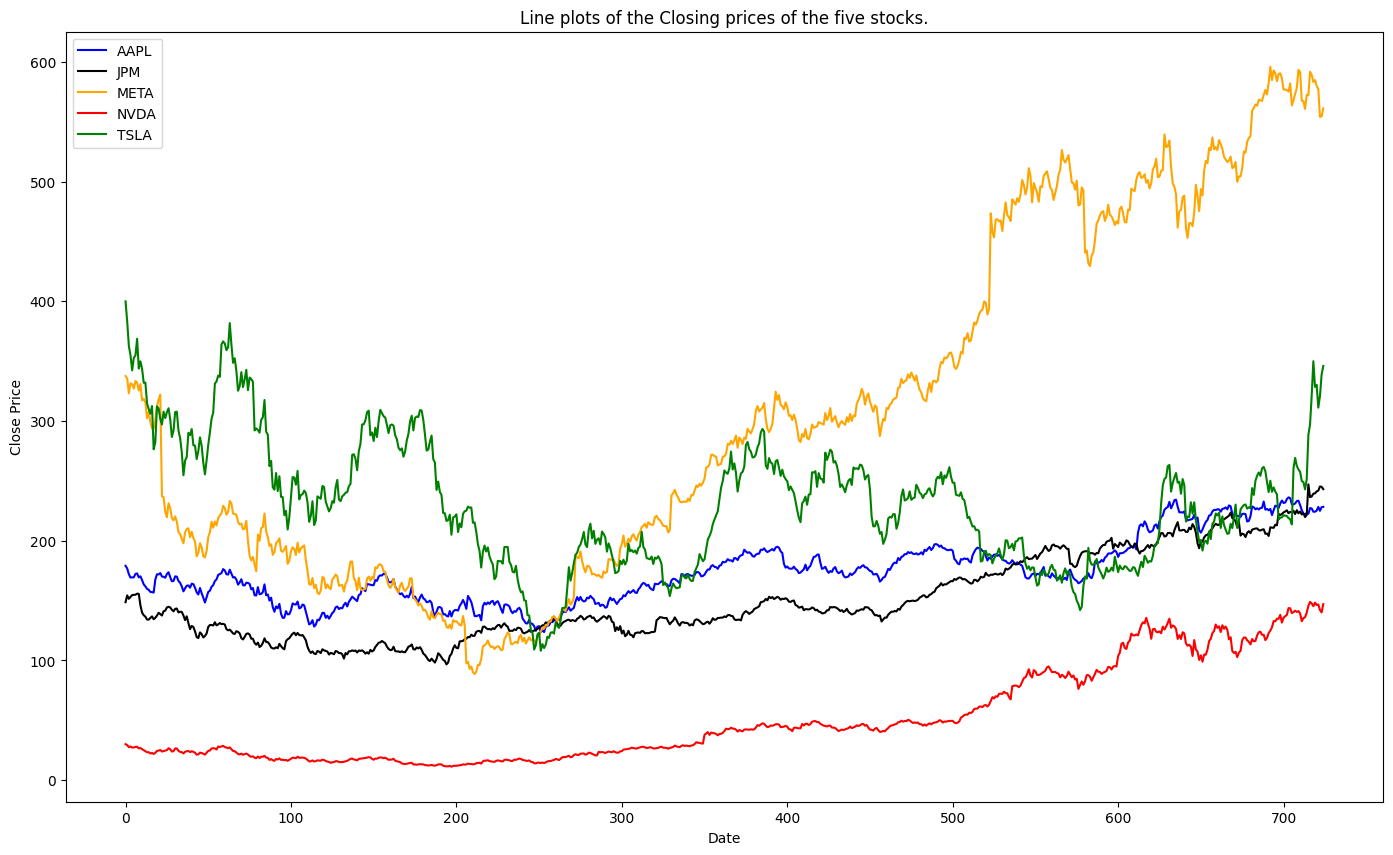

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(w=17, h=10)

# Convert Spark dataframes to Pandas dataframes in order to visualize them
pd_df = {}
for stock in stock_map:
  pd_df[stock] = stock_map[stock].toPandas()

# Define the colors for each line plot
colors = ["blue", "black", "orange", "red", "green"]

# Plot the five line plots
for i, stock in enumerate(pd_df):
  ax.plot(pd_df[stock]["Close"], color=colors[i], label=stock)

# Display information about the plots
ax.set_xlabel(xlabel="Date")
ax.set_ylabel(ylabel="Close Price")
ax.set_title(label="Line plots of the Closing prices of the five stocks.")
ax.legend()

plt.show()

From these plots, we observe that **TSLA** (in green) and **META** (in orange) exhibit very high volatility (can also be considered as unstable stocks) among the stocks. **NVDA** has the lowest closing prices, while **AAPL** and **JPM** appear to follow a somewhat similar trend.

## **Advanced explorations**

**The average of the opening and closing prices for each stock price and for
different time periods (week, month, year)**

For each dataframe, we will firstly add the **week**, the **month** and the **year** for each date.

In [ ]:
from pyspark.sql.functions import weekofyear, month, year

for stock in stock_map:
  stock_map[stock] = (stock_map[stock]
                      .withColumn("week", weekofyear(col("Date")))
                      .withColumn("month", month(col("Date")))
                      .withColumn("year", year(col("Date")))
                      )

# Example of result with AAPL stock
stock_map["AAPL"].show(6)

+---+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+----+-----+----+
| id|               Date|              Open|              High|               Low|             Close|   Volume|Dividends|Stock Splits|week|month|year|
+---+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+----+-----+----+
|  0|2022-01-03 05:00:00|174.96395910795226| 179.9325724934608| 174.8458979227722| 179.0765838623047|104487900|      0.0|         0.0|   1|    1|2022|
|  1|2022-01-04 05:00:00|179.68661899764498| 179.9916204306624|176.23317886967382| 176.8038330078125| 99310400|      0.0|         0.0|   1|    1|2022|
|  2|2022-01-05 05:00:00|176.71527555574892|177.26624778747964|171.82537447983776|172.10086059570312| 94537600|      0.0|         0.0|   1|    1|2022|
|  3|2022-01-06 05:00:00|169.91662049000044|172.47472273765217|168.87370673165287| 169.2279052

**Average by week of year**

In [ ]:
for stock in stock_map:
  print(stock)
  df = stock_map[stock].groupBy("year", "week").agg({"Open": "avg", "Close": "avg"}).orderBy("year", "week")
  df.show(6)
  print()

AAPL
+----+----+------------------+------------------+
|year|week|        avg(Close)|         avg(Open)|
+----+----+------------------+------------------+
|2022|   1|173.32087097167968| 174.2772086779275|
|2022|   2|170.81395263671874|170.14097378297726|
|2022|   3|163.06634521484375|165.51621233656317|
|2022|   4|159.51502685546876|159.51896305725649|
|2022|   5| 171.3412292480469|170.27058584705964|
|2022|   6|170.13901977539064|170.84437801816003|
+----+----+------------------+------------------+
only showing top 6 rows


JPM
+----+----+------------------+------------------+
|year|week|        avg(Close)|         avg(Open)|
+----+----+------------------+------------------+
|2022|   1| 152.4282989501953|152.17153561096907|
|2022|   2| 153.4167449951172| 154.4378317419916|
|2022|   3| 137.1024398803711|139.62279240176275|
|2022|   4|135.27947692871095|134.71343908890756|
|2022|   5| 138.9106201171875|137.61206356413066|
|2022|   6|143.45002136230468| 143.7533882299781|
+----+----+----

Let's have a gist of the variation of the average during the weeks.

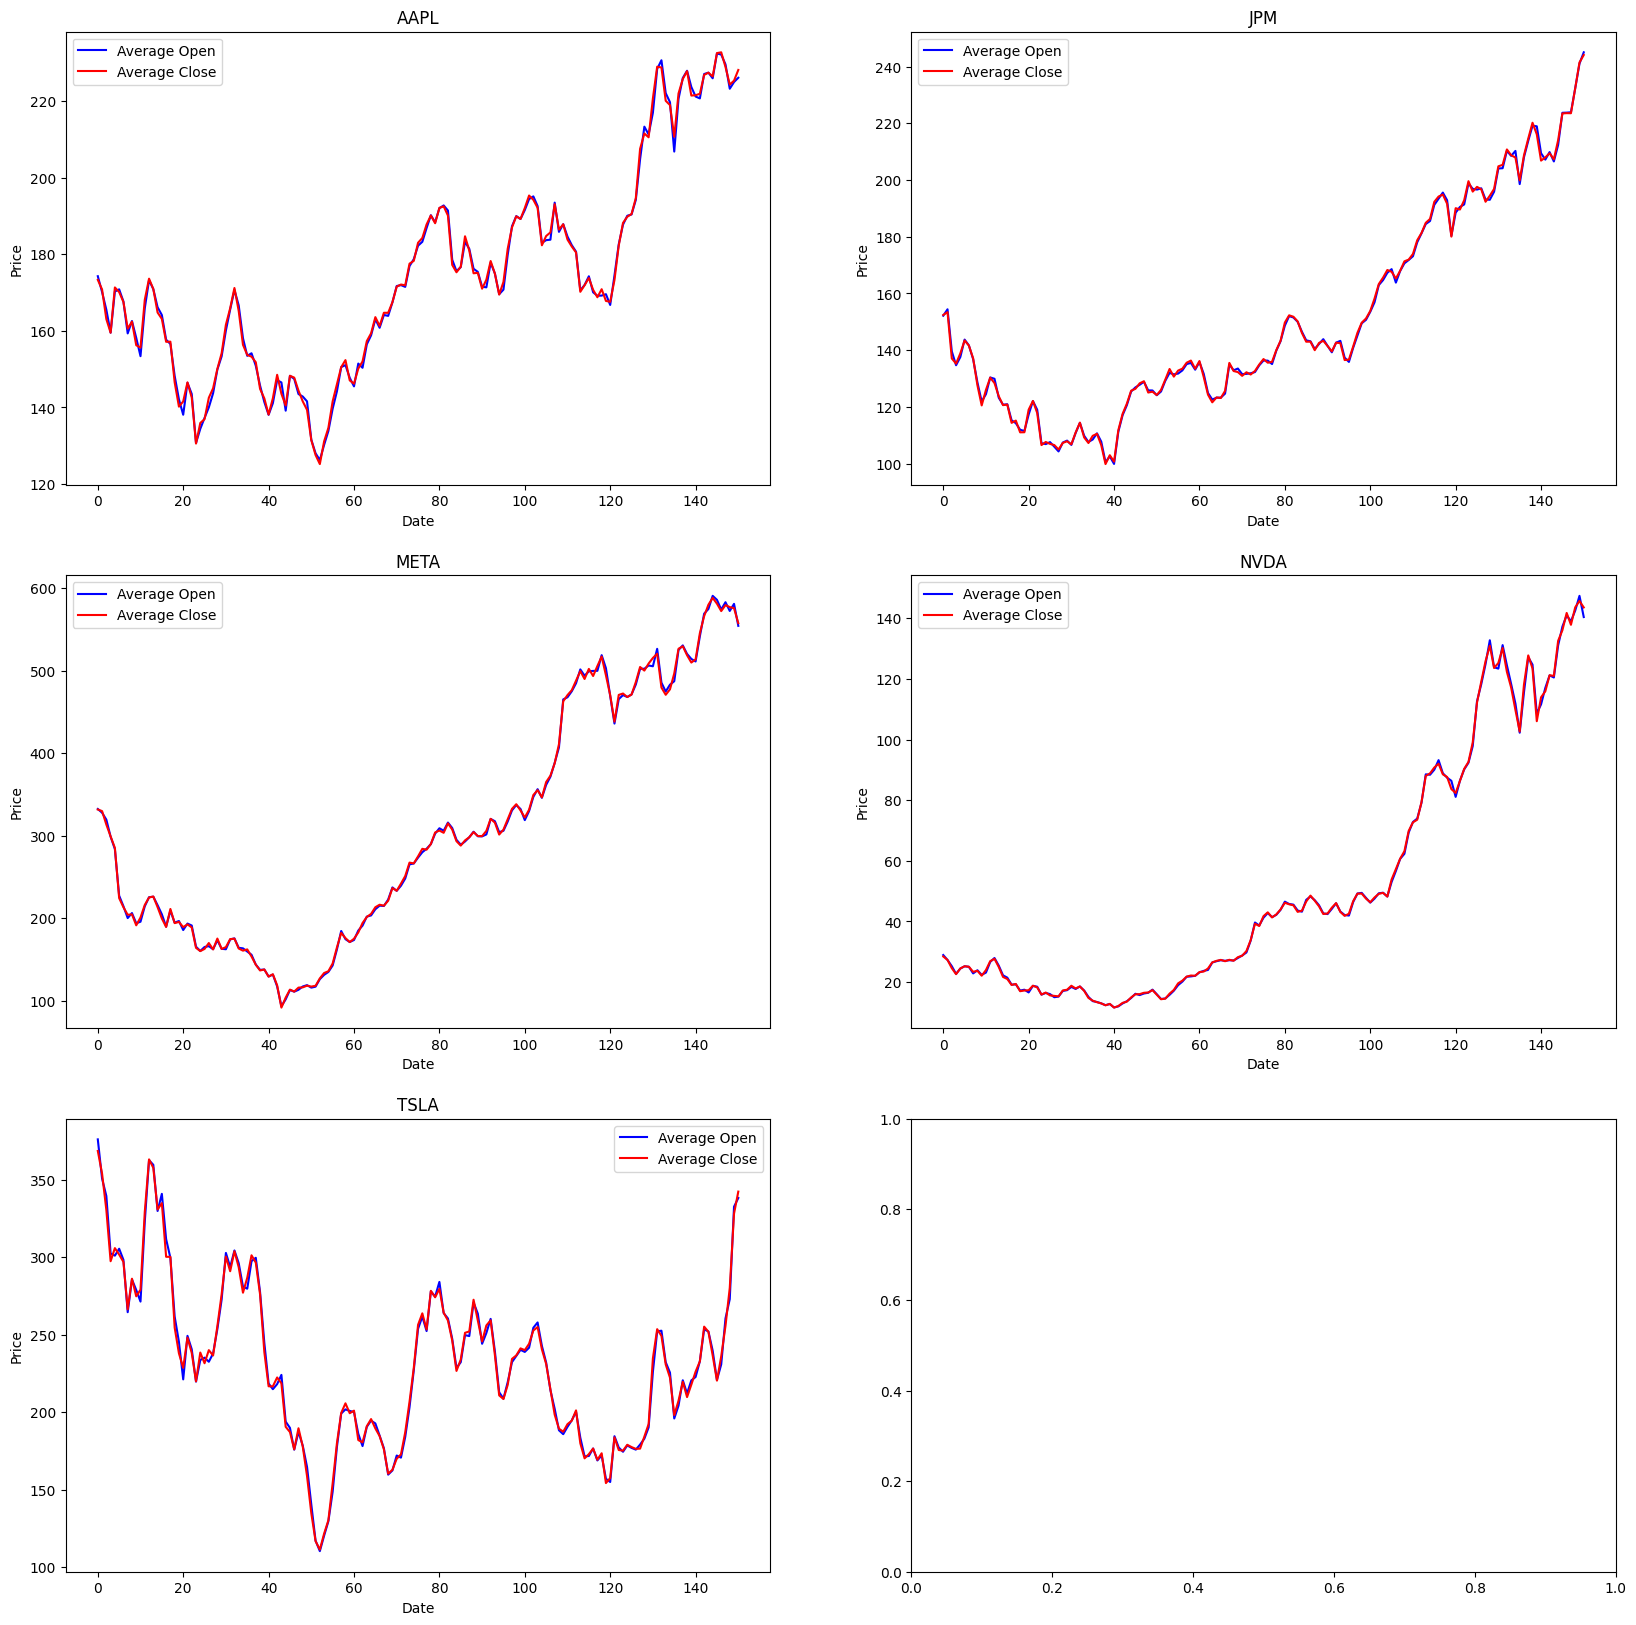

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(w=20, h=20)
cur_row = 0
cur_col = 0

for stock in stock_map:
  df = stock_map[stock].groupBy("year", "week").agg({"Open": "avg", "Close": "avg"}).orderBy("year", "week")
  df = df.toPandas()
  if cur_col == 2:
    cur_row += 1
    cur_col = 0
  ax[cur_row, cur_col].plot(df["avg(Open)"], color="blue", label="Average Open")
  ax[cur_row, cur_col].plot(df["avg(Close)"], color="red", label="Average Close")
  ax[cur_row, cur_col].set_xlabel(xlabel="Date")
  ax[cur_row, cur_col].set_ylabel(ylabel="Price")
  ax[cur_row, cur_col].set_title(label=stock)
  ax[cur_row, cur_col].legend()
  cur_col += 1

plt.show()


Plotting the weekly averages for the year suggests that the stock appear to be in a bull market, indicating a potential upward trend in the future. To gain a more detailed perspective, let's examine the monthly trend.

**Average by month**

In [ ]:
for stock in stock_map:
  print(stock)
  df = stock_map[stock].groupBy("year", "month").agg({"Open": "avg", "Close": "avg"}).orderBy("year", "month")
  df.show(6)
  print()

AAPL
+----+-----+------------------+------------------+
|year|month|        avg(Close)|         avg(Open)|
+----+-----+------------------+------------------+
|2022|    1| 167.1238868713379|167.45840728058752|
|2022|    2| 167.2712530838816|167.07941563343212|
|2022|    3|162.85339554496434|162.35739918169617|
|2022|    4|164.34150238037108|164.98972397348493|
|2022|    5|146.39503914969308|146.29040018515008|
|2022|    6|137.92306445893786|138.06823165689048|
+----+-----+------------------+------------------+
only showing top 6 rows


JPM
+----+-----+------------------+------------------+
|year|month|        avg(Close)|         avg(Open)|
+----+-----+------------------+------------------+
|2022|    1|144.57361907958983| 144.9903755927752|
|2022|    2|140.12224137155633|140.04873717544046|
|2022|    3|126.46951625658119|126.84872649899066|
|2022|    4|120.15141143798829|120.39915575574776|
|2022|    5|114.54197293236142|114.14131935639072|
|2022|    6| 111.7666760399228|112.351019105999

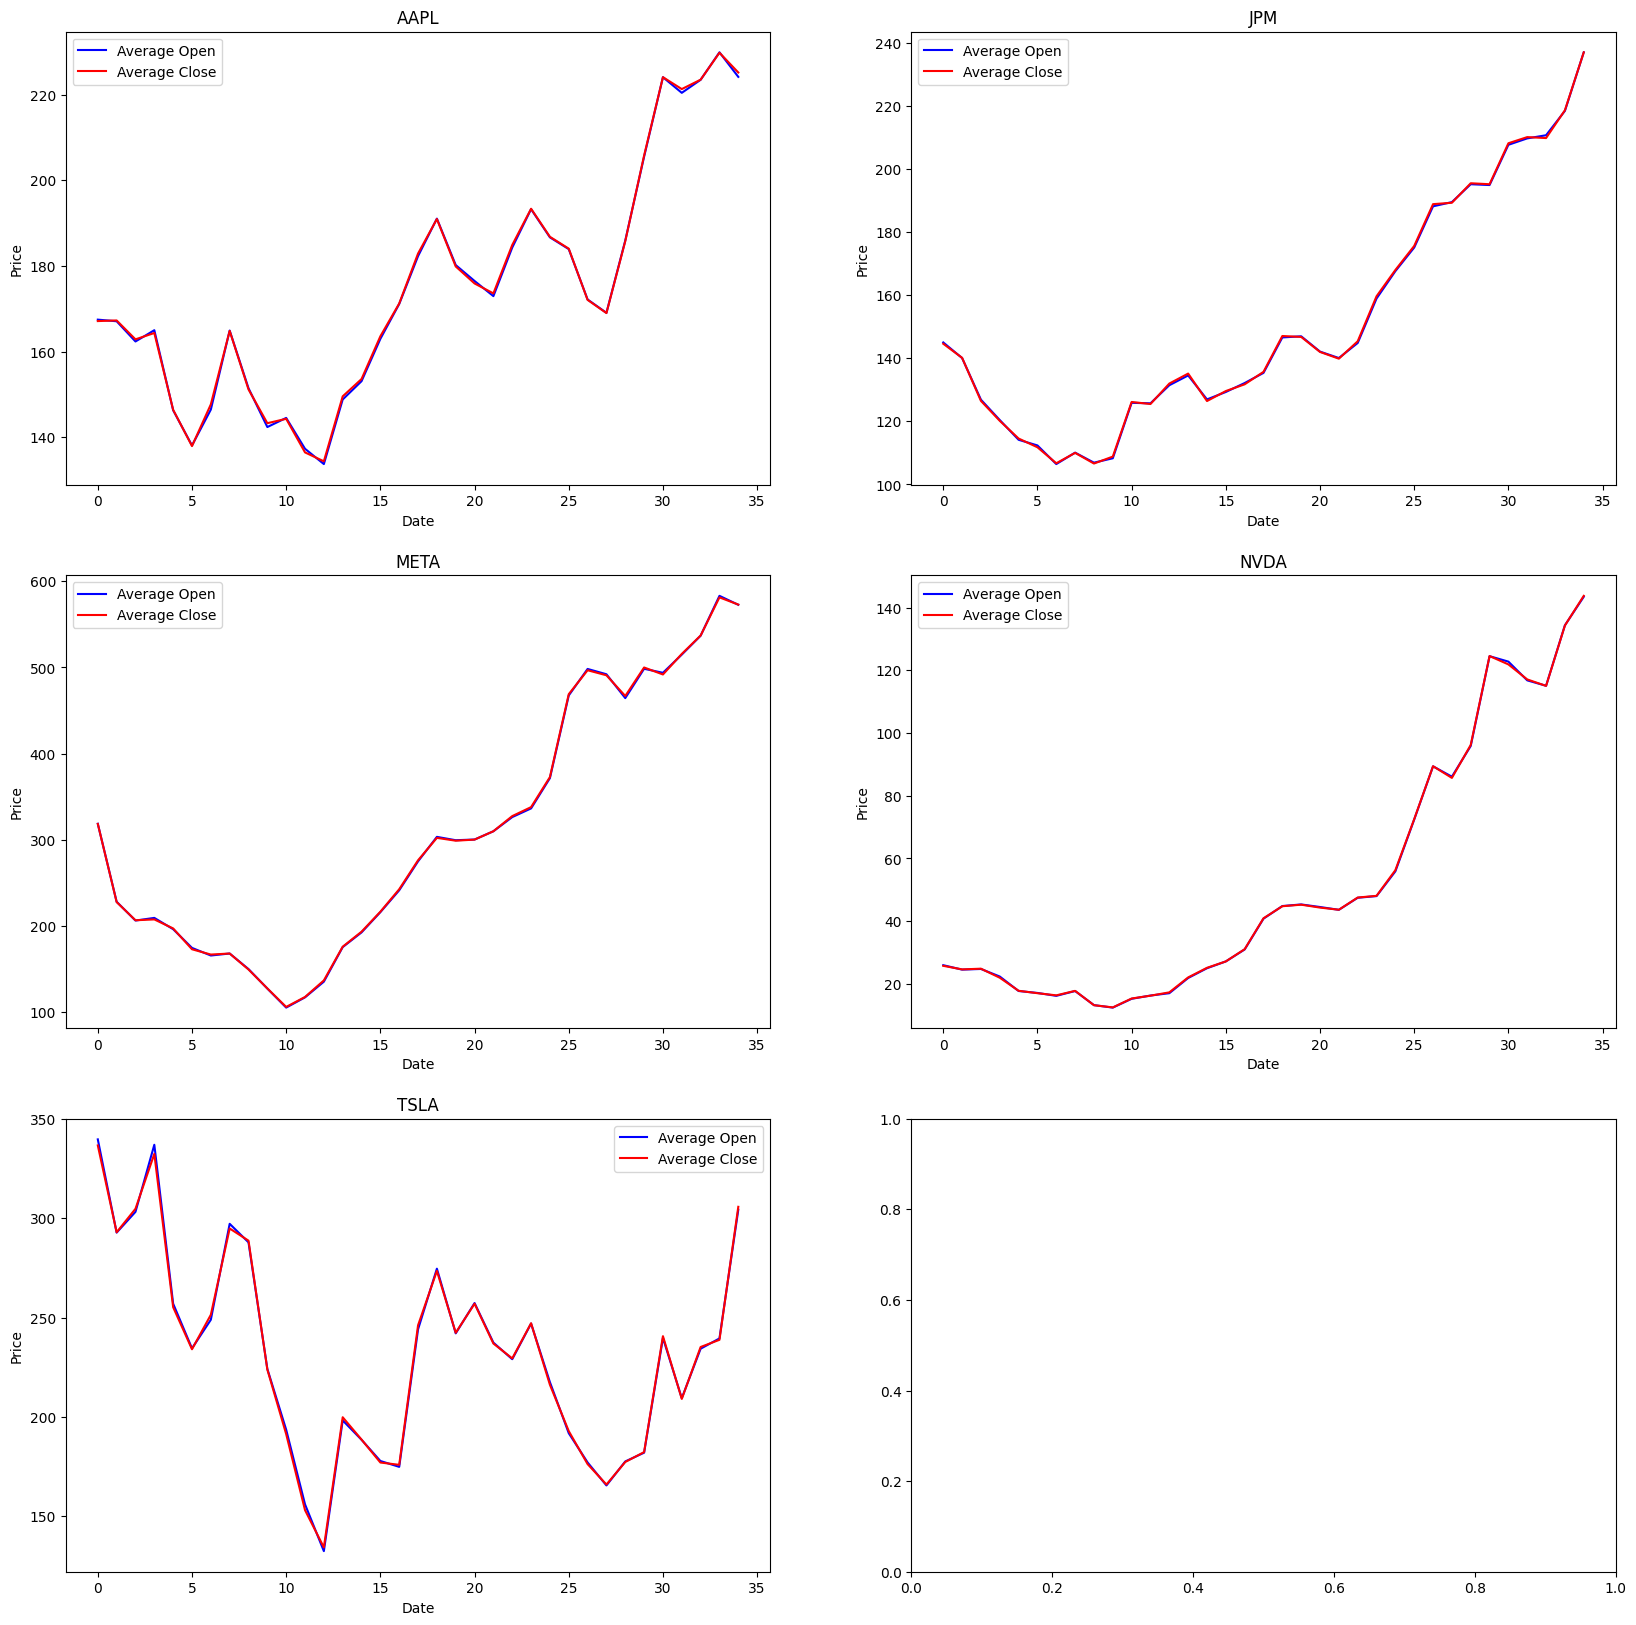

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(w=20, h=20)
cur_row = 0
cur_col = 0

for stock in stock_map:
  df = stock_map[stock].groupBy("year", "month").agg({"Open": "avg", "Close": "avg"}).orderBy("year", "month")
  df = df.toPandas()
  if cur_col == 2:
    cur_row += 1
    cur_col = 0
  ax[cur_row, cur_col].plot(df["avg(Open)"], color="blue", label="Average Open")
  ax[cur_row, cur_col].plot(df["avg(Close)"], color="red", label="Average Close")
  ax[cur_row, cur_col].set_xlabel(xlabel="Date")
  ax[cur_row, cur_col].set_ylabel(ylabel="Price")
  ax[cur_row, cur_col].set_title(label=stock)
  ax[cur_row, cur_col].legend()
  cur_col += 1

plt.show()

The monthly plots confirms our initial hypothesis on the tendency.

**Average by year**

In [ ]:
for stock in stock_map:
  print(stock)
  df = stock_map[stock].groupBy("year").agg({"Open": "avg", "Close": "avg"}).orderBy("year")
  df.show()
  print()


AAPL
+----+------------------+------------------+
|year|        avg(Close)|         avg(Open)|
+----+------------------+------------------+
|2022|152.77534548694868|152.74354136711827|
|2023|171.28199554443358| 170.9921463631193|
|2024| 201.9763320514134|201.82229130239108|
+----+------------------+------------------+


JPM
+----+------------------+------------------+
|year|        avg(Close)|         avg(Open)|
+----+------------------+------------------+
|2022|119.87992536689181|119.93748180210895|
|2023| 139.2003649597168|139.05109942205894|
|2024|198.60382870265417| 198.4018773973544|
+----+------------------+------------------+


META
+----+-----------------+------------------+
|year|       avg(Close)|         avg(Open)|
+----+-----------------+------------------+
|2022|179.6467949004762|179.69795511103928|
|2023|260.6395253601074|260.09592277126535|
|2024|497.4796746117728| 497.3842844127834|
+----+-----------------+------------------+


NVDA
+----+------------------+------------

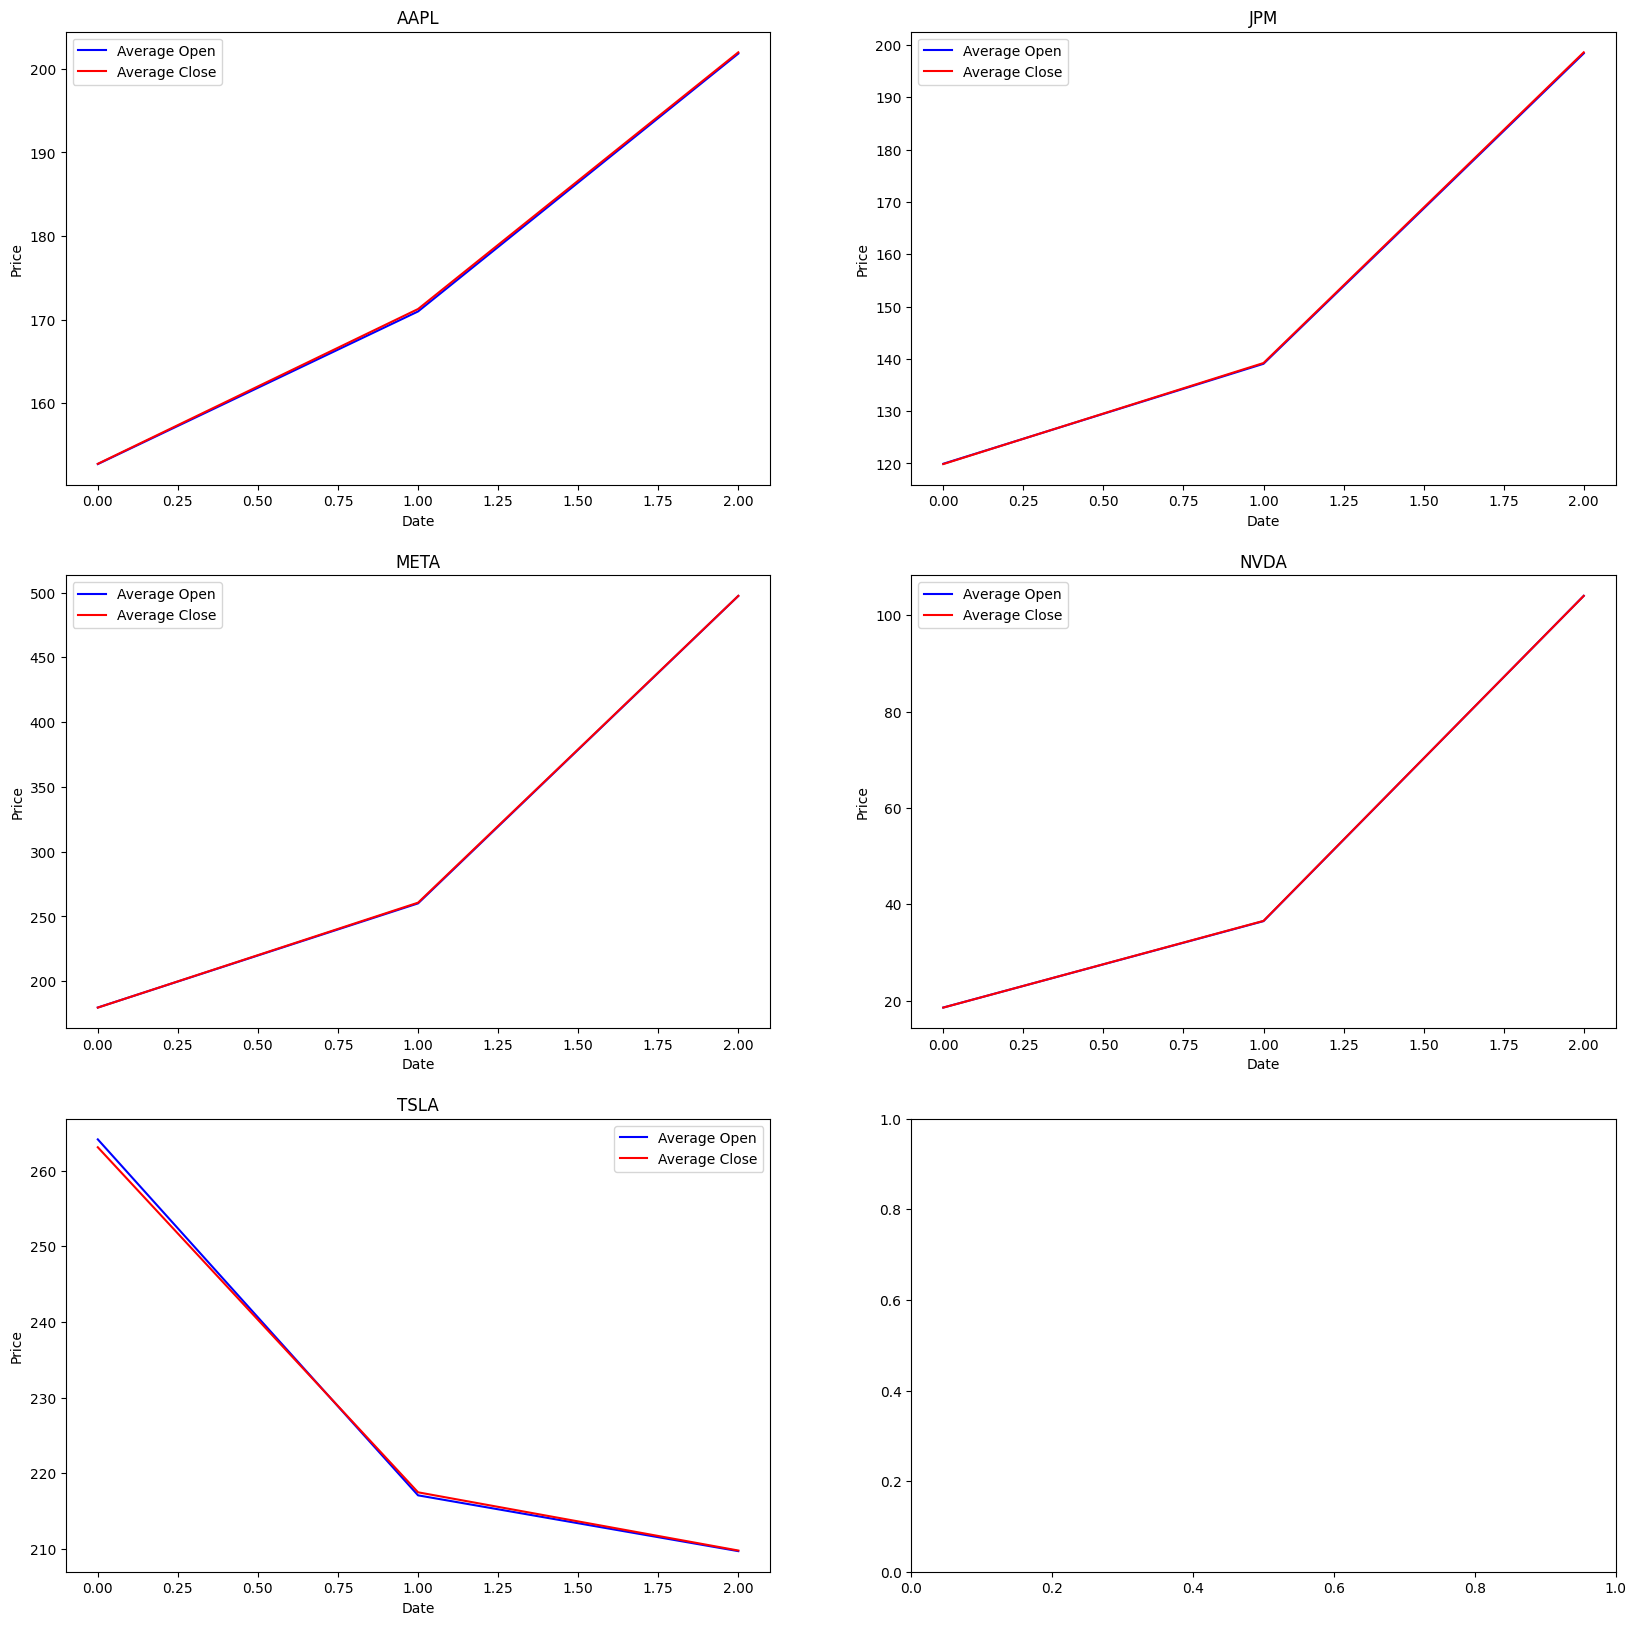

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(w=20, h=20)
cur_row = 0
cur_col = 0

for stock in stock_map:
  df = stock_map[stock].groupBy("year").agg({"Open": "avg", "Close": "avg"}).orderBy("year")
  df = df.toPandas()
  if cur_col == 2:
    cur_row += 1
    cur_col = 0
  ax[cur_row, cur_col].plot(df["avg(Open)"], color="blue", label="Average Open")
  ax[cur_row, cur_col].plot(df["avg(Close)"], color="red", label="Average Close")
  ax[cur_row, cur_col].set_xlabel(xlabel="Date")
  ax[cur_row, cur_col].set_ylabel(ylabel="Price")
  ax[cur_row, cur_col].set_title(label=stock)
  ax[cur_row, cur_col].legend()
  cur_col += 1

plt.show()


With a year point of view, **TSLA** seems to be in a bear market.

**How do the stock prices change day to day and month to month**

**Day-to-Day Changes**

*DDChange = Today's Closing Price - Yesterday's Closing Price*

In [ ]:
def dday_change(df):
  return (df.alias("df1")
          .join(other=df.alias("df2"), on=(col("df1.id")+1==col("df2.id")), how="inner")
          .withColumn("DDChange", (col("df2.Close") - col("df1.Close"))) # Computing of the day to day change
          .orderBy("df1.id")
          .select( # Selection of the columns
              col("df1.Date").alias("Yesterday"),
              col("df1.Close").alias("Yesterday_Closing_Price"),
              col("df2.Date").alias("Today"),
              col("df2.Close").alias("Today_Closing_Price"),
              "DDChange")
          )

In [ ]:
%%time

for stock in stock_map:
  print(stock)
  df = dday_change(stock_map[stock])
  df.show(10)
  print()

AAPL
+-------------------+-----------------------+-------------------+-------------------+-------------------+
|          Yesterday|Yesterday_Closing_Price|              Today|Today_Closing_Price|           DDChange|
+-------------------+-----------------------+-------------------+-------------------+-------------------+
|2022-01-03 05:00:00|      179.0765838623047|2022-01-04 05:00:00|  176.8038330078125|-2.2727508544921875|
|2022-01-04 05:00:00|      176.8038330078125|2022-01-05 05:00:00| 172.10086059570312| -4.702972412109375|
|2022-01-05 05:00:00|     172.10086059570312|2022-01-06 05:00:00|  169.2279052734375| -2.872955322265625|
|2022-01-06 05:00:00|      169.2279052734375|2022-01-07 05:00:00| 169.39517211914062|  0.167266845703125|
|2022-01-07 05:00:00|     169.39517211914062|2022-01-10 05:00:00| 169.41485595703125|  0.019683837890625|
|2022-01-10 05:00:00|     169.41485595703125|2022-01-11 05:00:00| 172.25828552246094| 2.8434295654296875|
|2022-01-11 05:00:00|     172.25828552246

**Month-to-Month Changes**

*MMChange = Current Month's Closing Price - Previous Month's Closing Price*

In [ ]:
def mmonth_change(df):
  # Get the last date of all of the months
  end_dates = df.groupBy("year", "month").agg({"Date": "max"}).withColumnRenamed("max(Date)", "maxDate").select("maxDate")
  # Join this dataframe to the previous one in order to get the closing prices of each month
  months_df = df.join(other=end_dates, on=(df.Date==end_dates.maxDate), how="inner").orderBy("year", "month")
  months_df = months_df.withColumn("id", monotonically_increasing_id()).drop("maxDate") # We reset the index and drop the maxDate column (not needed anymore)
  # Now, we can follow the same process as the previous one
  return (months_df.alias("months_df1")
          .join(other=months_df.alias("months_df2"), on=(col("months_df1.id")+1==col("months_df2.id")), how="inner")
          .withColumn("MMChange", (col("months_df2.Close") - col("months_df1.Close")))
          .orderBy("months_df1.id")
          .select(col("months_df1.Date").alias("Previous_Month"),
                  col("months_df1.Close").alias("Previous_Month_Closing_Price"),
                  col("months_df2.Date").alias("Current_Month"),
                  col("months_df2.Close").alias("Current_Month_Closing_Price"),
                  "MMChange"))

In [ ]:
for stock in stock_map:
  print(stock)
  df = mmonth_change(stock_map[stock])
  df.show(6)
  print()

AAPL
+-------------------+----------------------------+-------------------+---------------------------+-------------------+
|     Previous_Month|Previous_Month_Closing_Price|      Current_Month|Current_Month_Closing_Price|           MMChange|
+-------------------+----------------------------+-------------------+---------------------------+-------------------+
|2022-01-31 05:00:00|          171.96310424804688|2022-02-28 05:00:00|         162.66580200195312|  -9.29730224609375|
|2022-02-28 05:00:00|          162.66580200195312|2022-03-31 04:00:00|         172.01475524902344|  9.348953247070312|
|2022-03-31 04:00:00|          172.01475524902344|2022-04-29 04:00:00|          155.3068084716797| -16.70794677734375|
|2022-04-29 04:00:00|           155.3068084716797|2022-05-31 04:00:00|          146.8431854248047|    -8.463623046875|
|2022-05-31 04:00:00|           146.8431854248047|2022-06-30 04:00:00|         134.88580322265625|-11.957382202148438|
|2022-06-30 04:00:00|          134.88580322

**Daily return of each stock**

In [ ]:
def daily_return(df):
  return df.withColumn("Return", (col("Close") - col("Open")))

In [ ]:
for stock in stock_map:
  print(stock)
  daily_return(stock_map[stock]).show(15)
  print()

AAPL
+---+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+----+-----+----+-------------------+
| id|               Date|              Open|              High|               Low|             Close|   Volume|Dividends|Stock Splits|week|month|year|             Return|
+---+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+----+-----+----+-------------------+
|  0|2022-01-03 05:00:00|174.96395910795226| 179.9325724934608| 174.8458979227722| 179.0765838623047|104487900|      0.0|         0.0|   1|    1|2022|  4.112624754352424|
|  1|2022-01-04 05:00:00|179.68661899764498| 179.9916204306624|176.23317886967382| 176.8038330078125| 99310400|      0.0|         0.0|   1|    1|2022|-2.8827859898324846|
|  2|2022-01-05 05:00:00|176.71527555574892|177.26624778747964|171.82537447983776|172.10086059570312| 94537600|      0.0|         0.0|   1| 

**Stocks with the highest daily return**

To find the stocks with the highest daily return, we will compute the max daily return of all of them and find the ones with the highest return.

In [ ]:
df_max = {}
cur_max = float("-inf")
cur_stock = None
for stock in stock_map:
  df = daily_return(stock_map[stock])
  df_max[stock] = df.agg({"Return": "max"}).collect()[0][0]
  if df_max[stock] > cur_max:
    cur_stock = stock

# Display of the results
print("The highest daily return of each stock :", df_max)
print("The stock with the highest daily return is", cur_stock)

The highest daily return of each stock : {'AAPL': 13.469572802509646, 'JPM': 12.05999755859375, 'META': 28.282984853012636, 'NVDA': 8.389281858984447, 'TSLA': 33.46000671386719}
The stock with the highest daily return is TSLA


Over the last five years, **TSLA** is the stock that has the highest daily return.

**Average daily return for different periods (week, month, year)**

In [ ]:
def average_daily_return(df, time_period):
  return_df = daily_return(stock_map[stock])
  if time_period == "week":
    # We group by the year first to avoid situation like the 25th week of 2019 be added to the 25th week of 2020 to compute the average
    return return_df.groupBy("year", "week").agg({"Return": "avg"}).orderBy("year", time_period)
  elif time_period == "month":
    # As in the previous case, month of each year is considered separately
    return return_df.groupBy("year", "month").agg({"Return": "avg"}).orderBy("year", time_period)
  elif time_period == "year":
    return return_df.groupBy("year").agg({"Return": "avg"}).orderBy("year")
  return None

In [ ]:
for stock in stock_map:
  print(stock)
  print("Average daily return by week")
  average_daily_return(stock_map[stock], "week").show(6)
  print("Average daily return by month")
  average_daily_return(stock_map[stock], "month").show(6)
  print("Average daily return by year")
  average_daily_return(stock_map[stock], "year").show(6)

AAPL
Average daily return by week
+----+----+--------------------+
|year|week|         avg(Return)|
+----+----+--------------------+
|2022|   1| -0.9563377062478253|
|2022|   2|   0.672978853741489|
|2022|   3| -2.4498671217194214|
|2022|   4|-0.00393620178774654|
|2022|   5|  1.0706434009872452|
|2022|   6| -0.7053582427694038|
+----+----+--------------------+
only showing top 6 rows

Average daily return by month
+----+-----+--------------------+
|year|month|         avg(Return)|
+----+-----+--------------------+
|2022|    1|-0.33452040924961324|
|2022|    2| 0.19183745044949924|
|2022|    3|  0.4959963632681615|
|2022|    4| -0.6482215931138526|
|2022|    5| 0.10463896454300647|
|2022|    6|-0.14516719795264793|
+----+-----+--------------------+
only showing top 6 rows

Average daily return by year
+----+-------------------+
|year|        avg(Return)|
+----+-------------------+
|2022|0.03180411983043628|
|2023| 0.2898491813142934|
|2024|0.15404074902222512|
+----+-------------------

**Moving average of the opening prices**

We will use a **window function** with a window size equal to the number of points considered to compute the moving average.

In [ ]:
from pyspark.sql.functions import avg
from pyspark.sql.window import Window

def moving_average(df, column_name, nbr_of_points):
  window = Window.orderBy(col("Date")).rowsBetween(-nbr_of_points+1, 0)
  df = df.withColumn(column_name, avg(col("Open")).over(window))
  return df

In [ ]:
# Moving average of size 3 for all of the stocks

for stock in stock_map:
  print(stock)
  df = moving_average(stock_map[stock], "moving_avg", 3)
  df.select("Open", "moving_avg").show(10)
  print()

AAPL
+------------------+------------------+
|              Open|        moving_avg|
+------------------+------------------+
|174.96395910795226|174.96395910795226|
|179.68661899764498| 177.3252890527986|
|176.71527555574892|177.12195122044872|
|169.91662049000044|175.43950501446477|
|170.10356923829096|172.24515509468014|
|166.35497850794255| 168.7917227454113|
|169.54277308913493| 168.6671069451228|
|173.28153740021668| 169.7264296657647|
|172.94699315342262|171.92376788092474|
|168.57858676416953|171.60237243926963|
+------------------+------------------+
only showing top 10 rows


JPM
+------------------+------------------+
|              Open|        moving_avg|
+------------------+------------------+
|146.97341373906332|146.97341373906332|
|151.06468322460137|149.01904848183233|
|155.21659654378809| 151.0848978358176|
|154.37491893320808|153.55206623386584|
|153.22806561418446| 154.2731936970602|
|156.37270867131673|154.65856440623642|
|155.62355452717924|155.07477627089347|
| 15

**Correlation between the different stocks**


To find the correlation between two stocks, we find the correlation between their daily returns. Using our previous coded function and the .corr method of pyspark, we can do that.

In [ ]:
def correlation(stock1_df, stock2_df):
  return1_df = daily_return(stock1_df).select(col("Return").alias("return1"), col("id"))
  return2_df = daily_return(stock2_df).select(col("Return").alias("return2"), col("id"))
  return_df = return1_df.join(other=return2_df, on=(return1_df.id == return2_df.id), how="inner")
  return return_df.corr("return1", "return2")

In [ ]:
%%time

stocks = list(stock_map.keys())

for i in range(len(stocks)):
  for j in range(i+1, len(stocks)):
    corr = correlation(stock_map[stocks[i]], stock_map[stocks[j]])
    print("Correlation between", stocks[i], "and", stocks[j], "is", np.round(corr, 2))

Correlation between AAPL and JPM is 0.28
Correlation between AAPL and META is 0.51
Correlation between AAPL and NVDA is 0.35
Correlation between AAPL and TSLA is 0.56
Correlation between JPM and META is 0.23
Correlation between JPM and NVDA is 0.11
Correlation between JPM and TSLA is 0.27
Correlation between META and NVDA is 0.53
Correlation between META and TSLA is 0.46
Correlation between NVDA and TSLA is 0.36
CPU times: user 206 ms, sys: 32.4 ms, total: 239 ms
Wall time: 11.4 s


We can notice the tuple **AAPL** and **TSLA** have the strongest correlation (0.56). They are followed by the tuple **META** abd **NVDA** (0.53) and **AAPL** and **META** (0.51).

**Return rate of the stocks**

*RRate(%) = (Final Value of the period - Initial Value of the period) * 100 / Initial Value of the period*

In [ ]:
from pyspark.sql.functions import min, max

def return_rate(df, period):
  # Get the initial and the final date of the period considered.
  min_max_dates = (df.groupby(["year", period] if period in ["week", "month"] else ["year"])
                   .agg(
                       min("Date").alias("minDate"),
                       max("Date").alias("maxDate")
                  ))

  # Get the data related to the initial (min) and the final (max) dates and compute the return rate
  rrate_df = (min_max_dates
              .join(other=df.alias("initial"), on=(min_max_dates.minDate==col("initial.Date")), how="inner")
              .join(other=df.alias("final"), on=(min_max_dates.maxDate==col("final.Date")), how="inner")
              .withColumn("RRate", (col("final.Close") - col("initial.Close"))*100/col("initial.Close"))
              .select(
                  col("initial.Date").alias(f"Initial_{period}"),
                  col("initial.Close").alias(f"Initial_{period}_close"),
                  col("final.Date").alias(f"Final_{period}"),
                  col("final.Close").alias(f"Final_{period}_close"),
                  "RRate")
              .orderBy(col("initial.Date")))

  return rrate_df

In [ ]:
df = return_rate(stock_map["AAPL"], period="month")
df.show(6)

+-------------------+-------------------+-------------------+------------------+------------------+
|      Initial_month|Initial_month_close|        Final_month| Final_month_close|             RRate|
+-------------------+-------------------+-------------------+------------------+------------------+
|2022-01-03 05:00:00|  179.0765838623047|2022-01-31 05:00:00|171.96310424804688|-3.972311432815526|
|2022-02-01 05:00:00| 171.79586791992188|2022-02-28 05:00:00|162.66580200195312|-5.314485166910121|
|2022-03-01 05:00:00| 160.77432250976562|2022-03-31 04:00:00|172.01475524902344|  6.99143530122794|
|2022-04-01 04:00:00| 171.71920776367188|2022-04-29 04:00:00| 155.3068084716797|-9.557695674079577|
|2022-05-02 04:00:00|  155.6122283935547|2022-05-31 04:00:00| 146.8431854248047|-5.635188866116903|
|2022-06-01 04:00:00| 146.71495056152344|2022-06-30 04:00:00|134.88580322265625|-8.062673431435165|
+-------------------+-------------------+-------------------+------------------+------------------+


In [ ]:
# Return rate of the stocks by year

for stock in stock_map:
  print(stock)
  df = return_rate(stock_map[stock], period="year")
  df.show()

AAPL
+-------------------+------------------+-------------------+------------------+------------------+
|       Initial_year|Initial_year_close|         Final_year|  Final_year_close|             RRate|
+-------------------+------------------+-------------------+------------------+------------------+
|2022-01-03 05:00:00| 179.0765838623047|2022-12-30 05:00:00|128.57789611816406|-28.19949244897926|
|2023-01-03 05:00:00| 123.7684555053711|2023-12-29 05:00:00|191.59136962890625| 54.79822289661835|
|2024-01-02 05:00:00|184.73497009277344|2024-11-19 05:00:00|228.27999877929688| 23.57162191038071|
+-------------------+------------------+-------------------+------------------+------------------+

JPM
+-------------------+------------------+-------------------+------------------+------------------+
|       Initial_year|Initial_year_close|         Final_year|  Final_year_close|             RRate|
+-------------------+------------------+-------------------+------------------+------------------+


For the year **2022**, all of the stocks have negative return rate. **NVDA** has the best return rate in **2023** and **2024**.

**Stock with the best return rate**

In [ ]:
from dateutil.relativedelta import relativedelta

def best_rrate_stock(start_date, period):
  end_date = start_date + (relativedelta(months=1) if period == "month" else relativedelta(years=1))
  cur_stock, cur_max = None, float("-inf")
  for stock in stock_map:
    # Filter by the period considered
    df = stock_map[stock].filter((col("Date") >= start_date) & (col("Date") <= end_date))
    # Get the start and the end close prices of the considered period
    start_close = df.collect()[0]["Close"]
    end_close = df.collect()[df.count() - 1]["Close"]
    # Compute the return rate
    rrate = (end_close - start_close) * 100 / start_close
    # Update the values each time a better return rate is found
    if rrate > cur_max:
      cur_max = rrate
      cur_stock = stock
  return cur_stock

In [ ]:
# Stocks with the best return rate per month (2021-01-01 to 2024-09-31)
_date = datetime.strptime("2022-01-01", "%Y-%m-%d")
stock_occur_month = {stock : 0 for stock in stock_map}
for i in range(35):
  best = best_rrate_stock(_date + relativedelta(months=i), period="month")
  stock_occur_month[best] += 1
print(stock_occur_month)

print()

# Stocks with the best return rate per year: 2022-2023, 2023-2024
_date = datetime.strptime("2022-01-01", "%Y-%m-%d")
best = best_rrate_stock(_date, period="year")
print("Stock with the best return during the period 2022-2023:", best)
best = best_rrate_stock(_date+relativedelta(years=1), period="year")
print("Stock with the best return during the period 2023-2024", best)

{'AAPL': 4, 'JPM': 2, 'META': 6, 'NVDA': 11, 'TSLA': 12}

Stock with the best return during the period 2022-2023: JPM
Stock with the best return during the period 2023-2024 NVDA


## **8 insights**

### **Insight 1**

When we analyze the trends of all the stocks, they appear to be in a bullish market when viewed over **weekly** and **monthly** periods. Therefore, it will be a good opportunity for **swing traders** to **buy those stocks** waiting for their increase that can longer **from few days to few months**. In the case of **TSLA**, **long term traders** should be aware of the fact its price will probably decrease at the end of the year. So, strategies like **Buy and Hold** are less suitable for this stock during these times.

### **Insight 2**

If we take a look at the **daily returns**, there are a lot of **negative numbers** for all of the stocks. **Closing prices are therefore routinely lower than opening prices**. Based on the market trend (bullish or bearish), traders could make big profits in the long term. This indicator also shows that **day trading is not really advisable for the five stocks we analyzed**.


### **Insight 3**

There are **strong correlations** (almost perfect ones) between the **Open**, **Close**, **High** and **Low** prices of each of the stocks we analyze. This may indicate that for all of the five stocks, **the stock price remains relatively stable throughout the day**. For example, the spread between the opening and closing price could be small, and the extremes (the day's lows and highs) could be close to the opening and closing prices.

### **Insight 4**

Still on the subject of correlation, we can see that, even for different stocks, there is a **high correlation** (**Pearson's coefficient around 0.8**) between the variables **Open**, **Close**, **High** and **Close** for all stocks except TSLA. This could suggest a **general market sentiment** or even the **use of similar trading strategies** for these stocks.

### **Insight 5**

Considering the last three (03) years, **META** and **TSLA** seem to be very volatile and even unstable stocks. It is clearly stocks we will only recommend for experienced traders or those who want to take very big risks (and earn consequently) on the market. On the last **36 months**, we can notice the two stocks have the **best monthly returns rates** on about 50% of the time (**6** for **META** and **12** for **TSLA**). The fact TSLA has the **highest daily return** detected also explains its high volatility.

### **Insight 6**

There are no splits for **JPM** stock during the last five (03) years and its trend shows a **certain stability**. Through the analysis, we noticed it is the stock with the best return rate during the period **2022-2023**. It will be a very secure stock for someone who fear volatility and who wants to take few risks (and earn consequently) on the market.

### **Insight 7**

**NVDA** stock is the most traded stock out of the five we choose if we take a look at the volume. This would mean that this stock is of particular interest compared to other stocks. Looking at the information, it's clear that **NVIDIA** (the company behind this stock) has undergone significant changes in recent years. This is mainly due to its influence (notably through the marketing of GPUs) in the fast-growing field of **artificial intelligence.**. Our analysis also shows it is a stable stock and the stock with best return rate in **2022** and **2023**. If there is one stock we would suggest to those who want to invest among the five we analyzed, it would probably be this stock.

### **Insight 8**

The highest correlation between the five stocks is **0.56**, which is **not really sufficient** when talking about correlation. It means, the movement of one stock doesn't necessarily predict the movement of the other. It also implies that, someone who owns all of them is not exposed to combined loss at a time.

## **Sources**


### **Terminology**
* https://www.investopedia.com/terms/o/openingprice.asp
* https://www.investopedia.com/terms/c/closingprice.asp
* https://www.investopedia.com/terms/t/todayshigh.asp
* https://www.investopedia.com/terms/t/todayslow.asp
* https://www.investopedia.com/terms/v/volumeoftrade.asp
* https://www.investopedia.com/terms/d/dividend.asp
* https://www.investopedia.com/terms/s/stocksplit.asp
* https://www.investopedia.com/ask/answers/what-stock-split-why-do-stocks-split/
* https://www.investopedia.com/terms/m/movingaverage.asp



### **Code and implementation**

* https://github.com/kevinschaich/pyspark-cheatsheet
* https://www.geeksforgeeks.org/get-value-of-a-particular-cell-in-pyspark-dataframe/
* https://stackoverflow.com/questions/43406887/spark-dataframe-how-to-add-a-index-column-aka-distributed-data-index
* https://stackoverflow.com/questions/53336781/adding-a-new-column-in-the-first-ordinal-position-in-a-pyspark-dataframe
* https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
* https://stackoverflow.com/questions/33224740/best-way-to-get-the-max-value-in-a-spark-dataframe-column
* https://stackoverflow.com/questions/32550478/pyspark-take-average-of-a-column-after-using-filter-function
* https://medium.com/@shuklaprashant9264/moving-average-in-pyspark-52c74cc7ec8f
* https://polygon.io/blog/finding-correlation-between-stocks